# **CC6204 - Deep Learning**

### Estudiante: Andrés Calderón Guardia

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2024-09-10 00:49:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘diabetes_data_upload.csv’

diabetes_data_uploa     [ <=>                ]  33.87K  --.-KB/s    in 0.007s  

2024-09-10 00:49:27 (4.74 MB/s) - ‘diabetes_data_upload.csv’ saved [34682]



In [3]:
import csv

with open('diabetes_data_upload.csv') as inp, open('temp.csv', 'w') as out:
    reader = csv.reader(inp)
    writer = csv.writer(out, delimiter=',')
    #No need to use `insert(), `append()` simply use `+` to concatenate two lists.
    writer.writerow(['ID'] + next(reader))
    #Iterate over enumerate object of reader and pass the starting index as 1.
    writer.writerows([i] + row for i, row in enumerate(reader, 1))

In [4]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [5]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [6]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [7]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [8]:
#Packages to use pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

#Packages to data management
from sklearn import metrics, decomposition, manifold

import copy, random, time

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_data = data.TensorDataset(X_train, Y_train)
test_data = data.TensorDataset(X_test, Y_test)

In [10]:
#We explicitly set the random seed in order to get the same results in each run
SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [11]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 20

train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [12]:
#Class for our neural network. When a class inherits from torch.nn.Module,
#it automatically becomes a neural network

class MLP(nn.Module):
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.fc1 = nn.Linear(input_dim, 8)
    self.fc2 = nn.Linear(8, 8)
    self.fc3 = nn.Linear(8, output_dim)

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.relu(self.fc1(input))
    h_2 = F.relu(self.fc2(h_1))
    y_pred = F.sigmoid(self.fc3(h_2))

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred, h_2

In [13]:
# Create the model
INPUT_DIM = 16*1
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)
torch.save(model.state_dict(), 'initial-model.pt')

In [15]:
def calculate_accuracy(y_pred, y):
  y_pred = torch.round(y_pred)
  corrects = (y_pred == y).float().sum()
  return corrects / y.shape[0]

In [16]:
#Define a function to perform training

def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.to(device) #Labels

    optimizer.zero_grad() #Clean gradients

    y_pred, _ = model(x) #Feed the network with data

    loss = criterion(y_pred, y) #Compute the loss

    loss.backward() #Compute gradients

    optimizer.step() #Apply update rules

    acc = calculate_accuracy(y_pred, y) #Compute the accuracy

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
#Function to test neural network

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for
  #training (dropout for instance)
  model.eval()

  with torch.no_grad(): #disable the autograd engine (save computation and memory)

    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [19]:
#Let's perform the training

def model_training(epochs=100):
  best_test_loss = float('inf')

  train_loss_data = []
  test_loss_data = []

  for epoch in range(epochs):

    start_time = time.time()

    #Train + test cycles
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

    #If we find a smaller loss, we save the model
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model.state_dict(), 'best-model.pt')

    train_loss_data.append(train_loss)
    test_loss_data.append(test_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  return train_loss_data, test_loss_data

In [20]:
#Load the best model
train_loss_data, test_loss_data = model_training()
model.load_state_dict(torch.load('best-model.pt', weights_only=True))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.215 | Test Acc: 94.17%


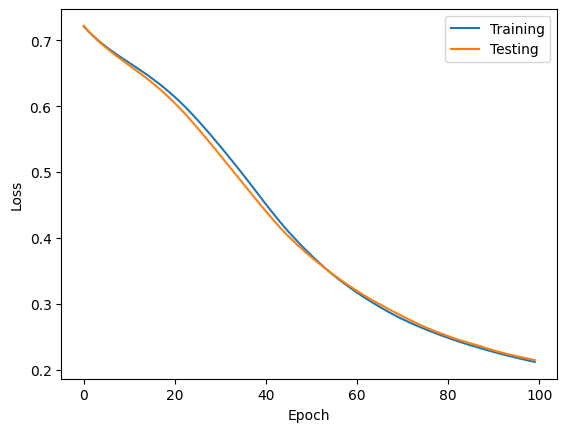

In [21]:
plt.plot(train_loss_data)
plt.plot(test_loss_data)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Testing"]);

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

m=1 | Test Loss: 0.100 | Test Acc: 97.50%
m=20 | Test Loss: 0.215 | Test Acc: 94.17%
m=50 | Test Loss: 0.423 | Test Acc: 80.83%
m=100 | Test Loss: 0.582 | Test Acc: 63.33%
m=200 | Test Loss: 0.647 | Test Acc: 63.33%
m=415 | Test Loss: 0.695 | Test Acc: 36.67%


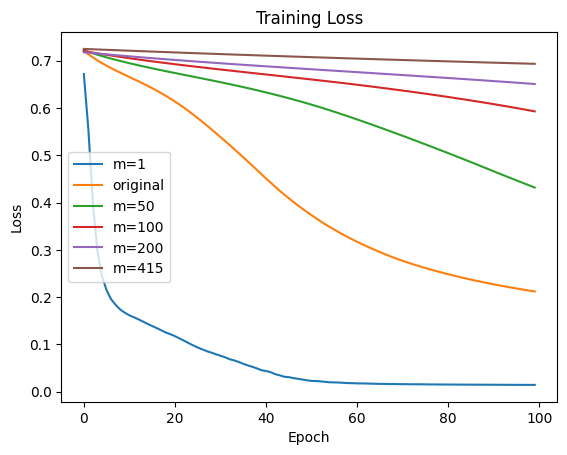

In [22]:
tests = []
for m in [1, 20, 50, 100, 200, 415]:
  train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=m)

  model.load_state_dict(torch.load('initial-model.pt', weights_only=True))
  train_loss_data, test_loss_data = model_training()
  tests.append(test_loss_data)

  plt.plot(train_loss_data)

  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f'm={m} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["m=1", "original", "m=50", "m=100", "m=200", "m=415"]);

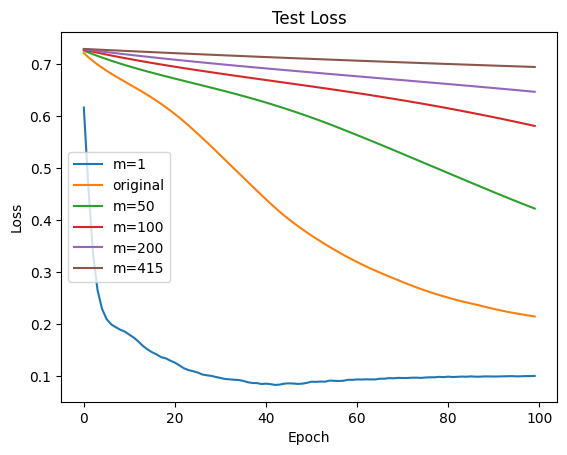

In [23]:
for batch in tests:
  plt.plot(batch)
plt.title("Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["m=1", "original", "m=50", "m=100", "m=200", "m=415"]);

Tanto para el training como para el testing los gráficos resultantes son bastante similares, de los cuales podría decirse que el la curva original se encuentra en un punto medio de los casos que se realizaron, de los cuales se evidencia que entre mayor sea el tamaño de los mini-batches, al loss le cuesta más llegar a valores pequeños para una misma cantidad de épocas.

Este comportamiento puede deberse a que al utilizar mayores tamaños en los mini-batches resulte en una convergencia más lenta al óptimo encontrado, además de que en contraste, al utilizar menores tamaños el modelo actualiza sus pesos más frecuentemente, lo cual efectivamente termina reduciendo su loss significativamente más rápido, pero además genera una curva más ruidosa en comparación a los tamaños superiores, lo cual es útil para lograr explorar más caminos con tal de hallar un mínimo local, situación que no se da para los grandes tamaños.

Finalmente respecto a los accuracies obtenidos se aprecian resultados esperables, dado que los porcentajes mejoran en los casos donde se obtuvo un menor loss, pues se redujo mejor la pérdida y con ello mejoraron las predicciones en el testeo.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

lr=0.5 | Test Loss: 0.096 | Test Acc: 97.50%
lr=0.1 | Test Loss: 0.116 | Test Acc: 95.83%
lr=0.01 | Test Loss: 0.215 | Test Acc: 94.17%
lr=0.0001 | Test Loss: 0.722 | Test Acc: 36.67%
lr=1e-05 | Test Loss: 0.729 | Test Acc: 36.67%
lr=1e-06 | Test Loss: 0.730 | Test Acc: 36.67%


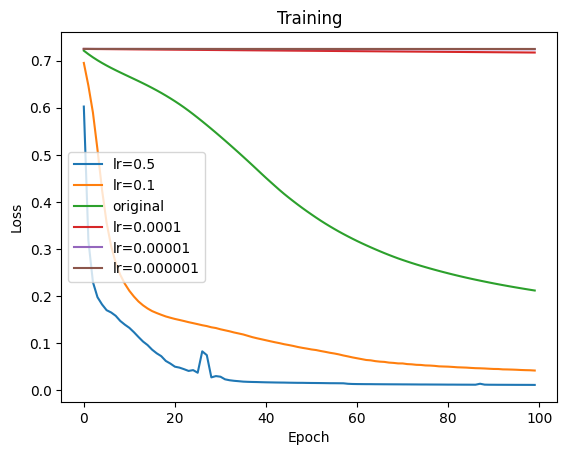

In [24]:
tests = []
train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=20)

for learning_rate in [0.5, 0.1, 0.01, 0.0001, 0.00001, 0.000001]:
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  model.load_state_dict(torch.load('initial-model.pt', weights_only=True))
  train_loss_data, test_loss_data = model_training()
  tests.append(test_loss_data)
  model.load_state_dict(torch.load('best-model.pt', weights_only=True))

  plt.plot(train_loss_data)

  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f'lr={learning_rate} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["lr=0.5", "lr=0.1", "original", "lr=0.0001", "lr=0.00001", "lr=0.000001"]);

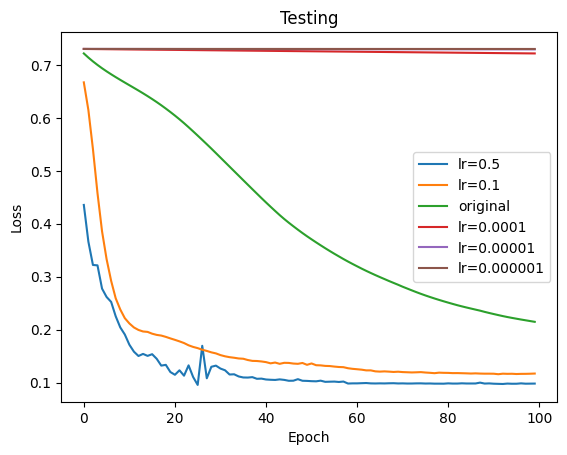

In [25]:
for batch in tests:
  plt.plot(batch)
plt.title("Testing")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["lr=0.5", "lr=0.1", "original", "lr=0.0001", "lr=0.00001", "lr=0.000001"]);

De forma similar al punto anterior, los gráficos expuestos para el training y el testing son bastante similares, mostrando que la curva original se presenta como un punto intermedio de los casos presentados nuevamente.

Para este caso, la influencia del learning rate en la curva de loss se presenta de forma que con un menor valor, al modelo le cuesta minimizar su pérdida, esto debido a que se "mueve" por los gradientes a un paso muy lento, de modo que para esta cantidad de épocas no logra bajar lo suficiente en comparación a learning rates más bajos. En contraste, los valores más altos convergen rápidamente a una baja pérdida, a cambio de poseer un comportamiento mucho más errático, principalmente notorio cuando se utiliza un valor de 0.5, lo cual es producido por dar grandes pasos por los gradientes.

Y con respecto a los accuracies, nuevamente se presenta que a medida que el loss aumenta este porcentaje disminuye, y en esta parte en particular el salto fue bastante más drástico, ya que usando un learning rate de hasta 0.01 el accuracy no bajó del 90%, pero al pasar a 0.0001 este valor cayó a un 36.67%, lo cual es apreciable también en el gráfico con el drástico cambio en las curvas que ocurre para este salto de valores.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

iteration=0 | Test Loss: 0.215 | Test Acc: 94.17%
iteration=1 | Test Loss: 0.214 | Test Acc: 94.17%
iteration=2 | Test Loss: 0.215 | Test Acc: 94.17%
iteration=3 | Test Loss: 0.213 | Test Acc: 94.17%
iteration=4 | Test Loss: 0.215 | Test Acc: 94.17%
iteration=5 | Test Loss: 0.214 | Test Acc: 94.17%


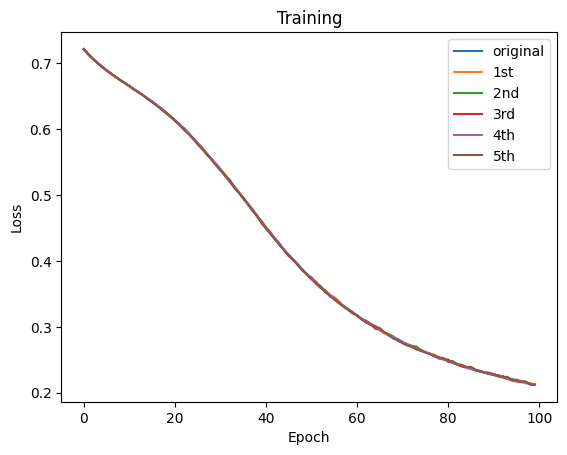

In [26]:
tests = []
train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=20)

for i in range(6):
  model.load_state_dict(torch.load('initial-model.pt', weights_only=True))
  optimizer = optim.SGD(model.parameters(), lr=0.01)
  train_loss_data, test_loss_data = model_training()
  tests.append(test_loss_data)

  plt.plot(train_loss_data)

  train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=20)

  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f'iteration={i} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["original", "1st", "2nd", "3rd", "4th", "5th"]);

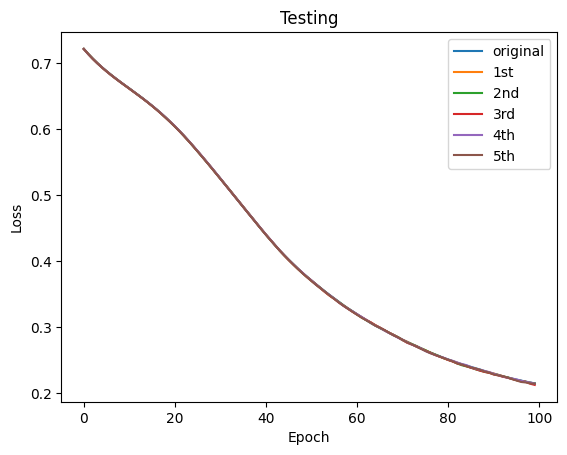

In [27]:
for batch in tests:
  plt.plot(batch)
plt.title("Testing")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["original", "1st", "2nd", "3rd", "4th", "5th"]);

Finalmente, en el caso de elegir los mini-batches de forma aleatoria, los gráficos presentados se ven casi idénticos, además de que las distintas ejecuciones también presentan curvas práctimente iguales al caso original, con la pequeña excepción de las curvas de loss en training, entre las 80 a 100 épocas, las cuales muy ligeramente presentan ruido respecto a la original.

Respecto al testeo, tiene sentido ya que si las curvas de training son muy similares entonces el loss del testing será en términos prácticos el mismo, ya que este no presenta aleatoriedad en la elección de los mini-batches.

Pero analizando el training, que las curvas sean tan similares podría deberse a varios factores, tales como que los datos estén bien distribuidos a lo largo de todo el set de datos, de forma que pese a la elección aleatoria de mini-batches, el entrenamiento sea igual de efectivo. Otro posible motivo sería que la estructura del modelo sea adecuada para ser robusta ante la aleatoriedad, de modo que signifique un verdadero aprendizaje sobre los datos pese a como se le sean entregados. Por último, también tienen que ver los hiperparámetros elegidos inicialmente, dado que un tamaño de 20 para los mini-batches y un learning rate de 0.01 son buenos valores los cuales generan resultados bastante estables.

Por último, los resultados obtenidos se condicen con los gráficos, puesto que, dado que estos son tan similares a lo largo de todas las épocas, también se aprecian porcentajes de accuracies iguales tras terminar el entrenamiento en cada ejecución realizada.